# Fraction PBHs and Coalesence Time
**References:**  [arXiv:1807.11489](https://arxiv.org/pdf/1807.11489.pdf).
###### Code Wirted By Tadeo D.

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import math
import seaborn as sb
import csv
from scipy import constants
from tqdm import tqdm
from scipy.integrate import quad, dblquad
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const
import astropy.units as u
from units import unit
from astropy.cosmology import Planck18, z_at_value
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
pl.rcParams['figure.figsize'] = (16, 9)
pl.style.use('ggplot')
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#
from mlxtend.plotting import plot_linear_regression

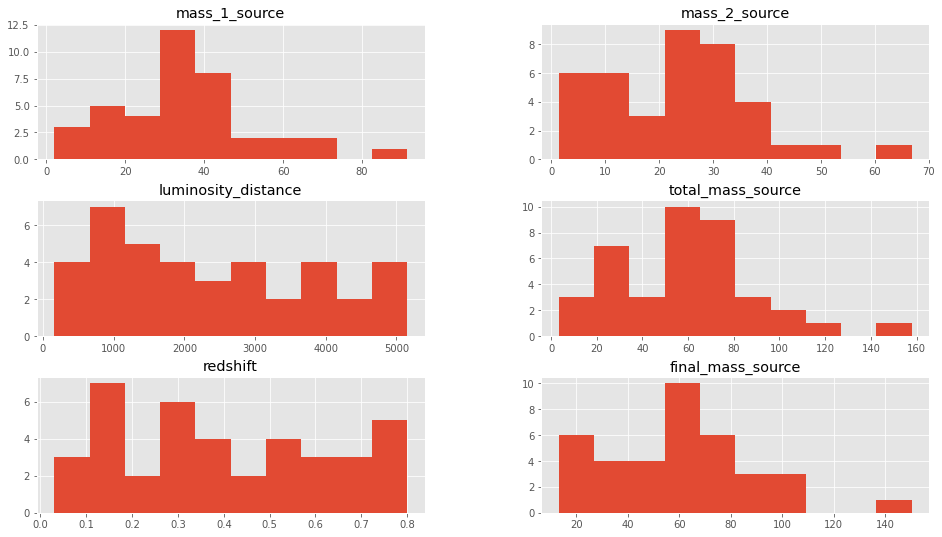

In [4]:
df = pd.read_csv('LIGO_events')
#print(df)
#df.shape
#df.head()
#df.describe()
df.drop(['id','version','GPS', 'mass_1_source_lower', 'mass_1_source_upper',
         'mass_2_source_lower', 'mass_2_source_upper', 'network_matched_filter_snr',
         'network_matched_filter_snr_lower', 'chirp_mass', 'redshift_lower', 'redshift_upper',
         'far','far_lower','far_upper','final_mass_source_lower','final_mass_source_upper',
         'chirp_mass_upper','chirp_mass_lower','reference','jsonurl','catalog.shortName','chirp_mass_source',
         'chirp_mass_source_lower','chirp_mass_source_upper','network_matched_filter_snr_upper','luminosity_distance_lower',
         'luminosity_distance_upper','chi_eff','chi_eff_lower','chi_eff_upper','total_mass_source_lower','total_mass_source_upper'],1).hist()
#pl.savefig('input_characteristics.png', dpi=300, bbox_inches='tight')
pl.show()

In [5]:
H0 = cosmo.H(0)  #cosmo.H(0)  <Quantity 67.66 km / (Mpc s)>
#print(((1/H0)*3.08e+19*u.km/u.megaparsec).to(u.Gyr))
#e = [0.5,  0.2,  0.1,  0.05,  0.01] #Excentricity array of datas
e = 0.1 #Half
a = [0.1] #Half Separation
#a = [0.001, 0.01, 0.1, 1, 7.63] #Separation in AU, the last one is 1pc = 208232 UA
#omega_m = 0.321
z_eq = 3411
omega_rd = 8.070427106422706e-5


def F(e): #Celoria's Equation (2.13) 
    F = (1-e**2)**(-3.5)*(1 + (73/24)*e**2 + (37/96)*e**4)
    return F

def t_coal(M1, M2, a, F): #Celoria's Equation (2.17)
    t = (5/256)*(const.c**5/const.G**3)*(((a*u.au).to(u.meter))**4 / (M1*M2*(M1 + M2)))*(1/F) #I did use a convertion AU to Meter to eliminate units from const.G
    return t #this variable has seconds units


def a_0(M1, M2, t, F):# Celoria's Equation (2.18)
    #time_coal_eq = 8.605200594749636*(u.Gyr) - cosmo.age(z_eq) #tiempo de coalesencia desde t_equivalencia
    q = M2/M1
    a_sep = 1.6*(const.R_sun)*((M1/const.M_sun)**0.75)*((q*(1+q)*F*(t/u.Gyr))**0.25)
    return a_sep

def Rs(M): #Schwarzschild radius equation
    R = 2*const.G*M/(const.c**2)
    return R

#def Z(D): #Redshift from Luminosity Distance
#    z = (H0/const.c)*D
#    return z

#def a_1(M1, M2, t, F):# Celoria's Equation (2.18)
#    #time_coal_eq = 8.605200594749636*(u.Gyr) - cosmo.age(z_eq) #tiempo de coalesencia desde t_equivalencia
#    q = M2/M1
#    a_sep = 1.6*(const.R_sun)*((M1/u.M_sun)**0.75)*((q*(1+q)*F*(t/u.Gyr))**0.25)
#    return a_sep

def integrand(z):
    omega_r = 8.070427106422706e-5 
    omega_m = 0.3
    omega_lmd = (0.7 - 8.070427106422706e-5)
    omega_k = 0
    return 1/((1+z)*((omega_r*((1+z)**4)) + 
                     (omega_m*((1+z)**3)) + 
                     (omega_lmd) + 
                     (omega_k*((1+z)**2)))**(1/2))

def H(z_eq):
    omega_m = 0.321 #From Planck / Arxiv:1807.06209
    omega_eo = 1.0 -  omega_rd - omega_m
    H_eq = (H0**2*(omega_rd*(1+z_eq)**4 + omega_m*(1+z_eq)**3 + omega_eo))**(0.5)
    return H_eq


def fc(H_e, M_pbh, l):
    omega_m_eq = (omega_rd)*(1+z_eq)**4
    fact = M_pbh*8*math.pi*const.G/(3*(H_e**2)*(l**3)*omega_m_eq) #l is the separation variable
    return fact*9.521e+38*(u.km**2)/(u.megaparsec**2)

#print("factor: ", fc(H(3411)))

print(cosmo.age(z_eq))

5.077592949554225e-05 Gyr


In [11]:
data_row=[]
with open('LIGO_events', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',', quotechar=':')
    for row in reader:
            string=[row['commonName'], row['mass_1_source'],
                    row['mass_2_source'], row['luminosity_distance'], 
                    row['redshift'], row['total_mass_source']] #If I need to get a new row only write its name
            data_row.append(string)
m_min = []
m_max = []
cosmic_time = []
coal_time = []
pr_z=[]
f_m1=[]
f_m2=[]
m1=[]
m2=[]
for i in range(len(data_row)):
    event = data_row[i]
    date = event[0]
    mass1 = float(event[1])*const.M_sun
    m1.append(float(event[1]))
    mass2 = float(event[2])*const.M_sun
    m2.append(float(event[2]))
    dist_lum = float(event[3])*u.megaparsec
    redshift = float(event[4])
    total_mass = float(event[5])*const.M_sun 
    if mass1 > mass2: #Conditional sentece to choose the mass mini and mass max
        m_min.append(mass2/u.kg)
        m_max.append(mass1/u.kg)
    elif mass2 > mass1:
        m_min.append(mass1/u.kg)
        m_max.append(mass2/u.kg)
    print("LIGO Event:", event , "    Half Exectricity   e =", e)
    for j in a: #For each value of Separation ###IMPORTANT CORREGIR DESDE AQUI
        time = t_coal(mass1, mass2,j,F(e))
        coal_time.append(time.to(u.year)/u.year)#save each value of t_coal in coal_time[]
        dl = dist_lum
        pr_z.append(redshift)
        red_Z = redshift
        I, err = quad(integrand, 0, red_Z)#integral to get cosmic time
        #cosmic_t = (cosmo.age(0) - I*cosmo.age(0))
        cosmic_t = (cosmo.age(0) - I*1/H0)
        #cosmic_t = (cosmo.age(0) - I*cosmo.age(0))
        t_coal_eq = cosmic_t - cosmo.age(z_eq)
        #cosmic_time.append((cosmo.age(0) - I*cosmo.age(0))/u.Gyr)
        cosmic_time.append((cosmo.age(0) - I*(1/H0))/u.Gyr)#save each value of integral from redshift to each event
        print("T_coal=", time.to(u.Gyr)) #convertion Seconds to Years
        #print("Cosmic Time=", (cosmo.age(0)-(I*(1/H0))))#comsmo.age(0) is 1/Ho constant into integral 
        print("Cosmic Time=", cosmic_t)#comsmo.age(0) is 1/Ho constant into integral
        print("T_Coal_age_equivalence: ", t_coal_eq)
        #print("Schwarzschild radius to M1, R =", (Rs(mass1).to(u.km)), "and M2, R =", (Rs(mass2).to(u.km)))
        #print("Redshift=",red_Z)
        separation = a_0(mass1, mass2, t_coal_eq, F(e))
        print("Separation: ", separation.to(u.AU))
        factor_m1 = fc(H(z_eq), mass1, separation)
        factor_m2 = fc(H(z_eq), mass2, separation)
        f_m1.append(factor_m1)
        f_m2.append(factor_m2)
        print("whit mass1", mass1/const.M_sun, "the factor is:", factor_m1)
        print("whit mass2", mass2/const.M_sun, "the factor is:", factor_m2)
    print("\n")

LIGO Event: ['GW190408_181802', '24.5', '18.3', '1580.0', '0.3', '42.9']     Half Exectricity   e = 0.1
T_coal= 1.5679400447303082 Gyr
Cosmic Time= 10.250442240306352 Gyr
T_Coal_age_equivalence:  10.250391464376857 Gyr
Separation:  0.15927345721062164 AU
whit mass1 24.5 the factor is: 1616360.0082808216
whit mass2 18.3 the factor is: 1207321.9653689403


LIGO Event: ['GW190412', '30.0', '8.3', '740.0', '0.15', '38.4']     Half Exectricity   e = 0.1
T_coal= 3.1549484974411346 Gyr
Cosmic Time= 11.83547821955633 Gyr
T_Coal_age_equivalence:  11.835427443626836 Gyr
Separation:  0.13862404762279015 AU
whit mass1 30.0 the factor is: 3001979.772738957
whit mass2 8.3 the factor is: 830547.7371244448


LIGO Event: ['GW190413_052954', '33.4', '23.4', '4100.0', '0.66', '56.9']     Half Exectricity   e = 0.1
T_coal= 0.6777659320116286 Gyr
Cosmic Time= 7.503726505150451 Gyr
T_Coal_age_equivalence:  7.503675729220955 Gyr
Separation:  0.1816934359432494 AU
whit mass1 33.4 the factor is: 1484331.782911

T_coal= 15.602515531342082 Gyr
Cosmic Time= 11.719419663967908 Gyr
T_Coal_age_equivalence:  11.719368888038414 Gyr
Separation:  0.0927295297553509 AU
whit mass1 12.299999999999999 the factor is: 4112000.6299946937
whit mass2 7.8 the factor is: 2607610.155606391




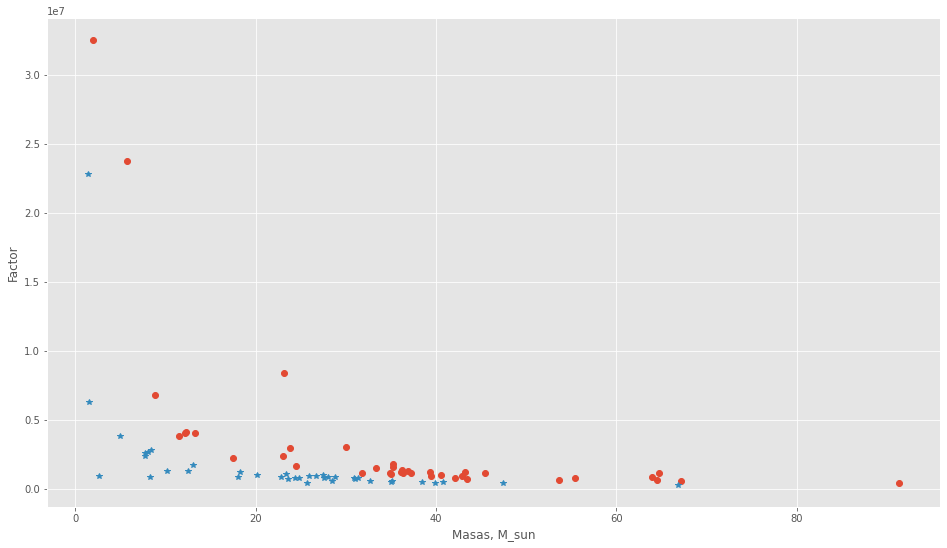

In [33]:
pl.xlabel("Masas, M_sun")
pl.ylabel("Factor")
pl.plot(m1, f_m1,'o') #Masas primarias círculo rojo
pl.plot(m2, f_m2,'*') #Masas secundarias asterisco
pl.show()

In [24]:
mass_sun_in = float(input("Please write the value of mass without units:    "))

def s(H_eq):
    #h = 0.674
    #rho_eq_crit = 2.7754e5*h**2*u.M_sun*u.parsec**-3
    M_pbh = mass_sun_in*const.M_sun
    omega_m_eq = (omega_rd)*(1+z_eq)**4
    factor=200.0
    l = (((M_pbh*8*math.pi*const.G)/(3*(H_eq**2)*factor*omega_m_eq))*(1e-6*u.km**2/u.m**2)*(3.24078e-23*u.megaparsec/u.m))**(1/3) #I need to change mega parsec to parsec
    return l

print("Separation:   ", s(H(3411)).to(u.AU))

Please write the value of mass without units:    40
Separation:    3.763716906092004 AU
